In [1]:
!pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl.metadata (1.8 kB)
Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [31]:
import os


import numpy as np
import pandas as pd
import datetime as dt


from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

import functions
from functions import return_months, mann_kendall, sens_slope, lr

In [32]:
os.getcwd()

'/home/jovyan/project/columbia-drivt/Methods'

In [33]:
df = pd.read_excel('/home/jovyan/project/columbia-drivt/Data/dalles_outflow.xlsx')
dalles_df = df
dalles_df.tail(3)

source  gauge_id     months      cfs  tmax  tmin  tmean
12050   USGS  14105700 2023-09-28  87000.0  19.4  19.2   19.3
12051   USGS  14105700 2023-09-29  89100.0  19.2  18.9   19.1
12052   USGS  14105700 2023-09-30  88200.0  19.1  18.8   19.0

In [34]:
# Convert the 'months' column to datetime format
dalles_df['months'] = pd.to_datetime(dalles_df['months'])

# Set the 'months' column as the index
dalles_df.set_index('months', inplace=True)

In [35]:
# Define time periods and seasons
periods = [
    {'label': '(1990-2010)', 'start': '1990-10-01', 'end': '2010-09-30'},
    {'label': '(2010-2020)', 'start': '2010-10-01', 'end': '2020-09-30'},
]

# Season Name, Season Months
seasons = {
    'Spring (March - May)': [3, 4, 5], # Spring
    'Summer (June - August)': [6, 7, 8], # Summer
    'Fall (September - November)': [9, 10, 11], # Fall
    'Winter (December - February)': [12, 1, 2], # Winter
}


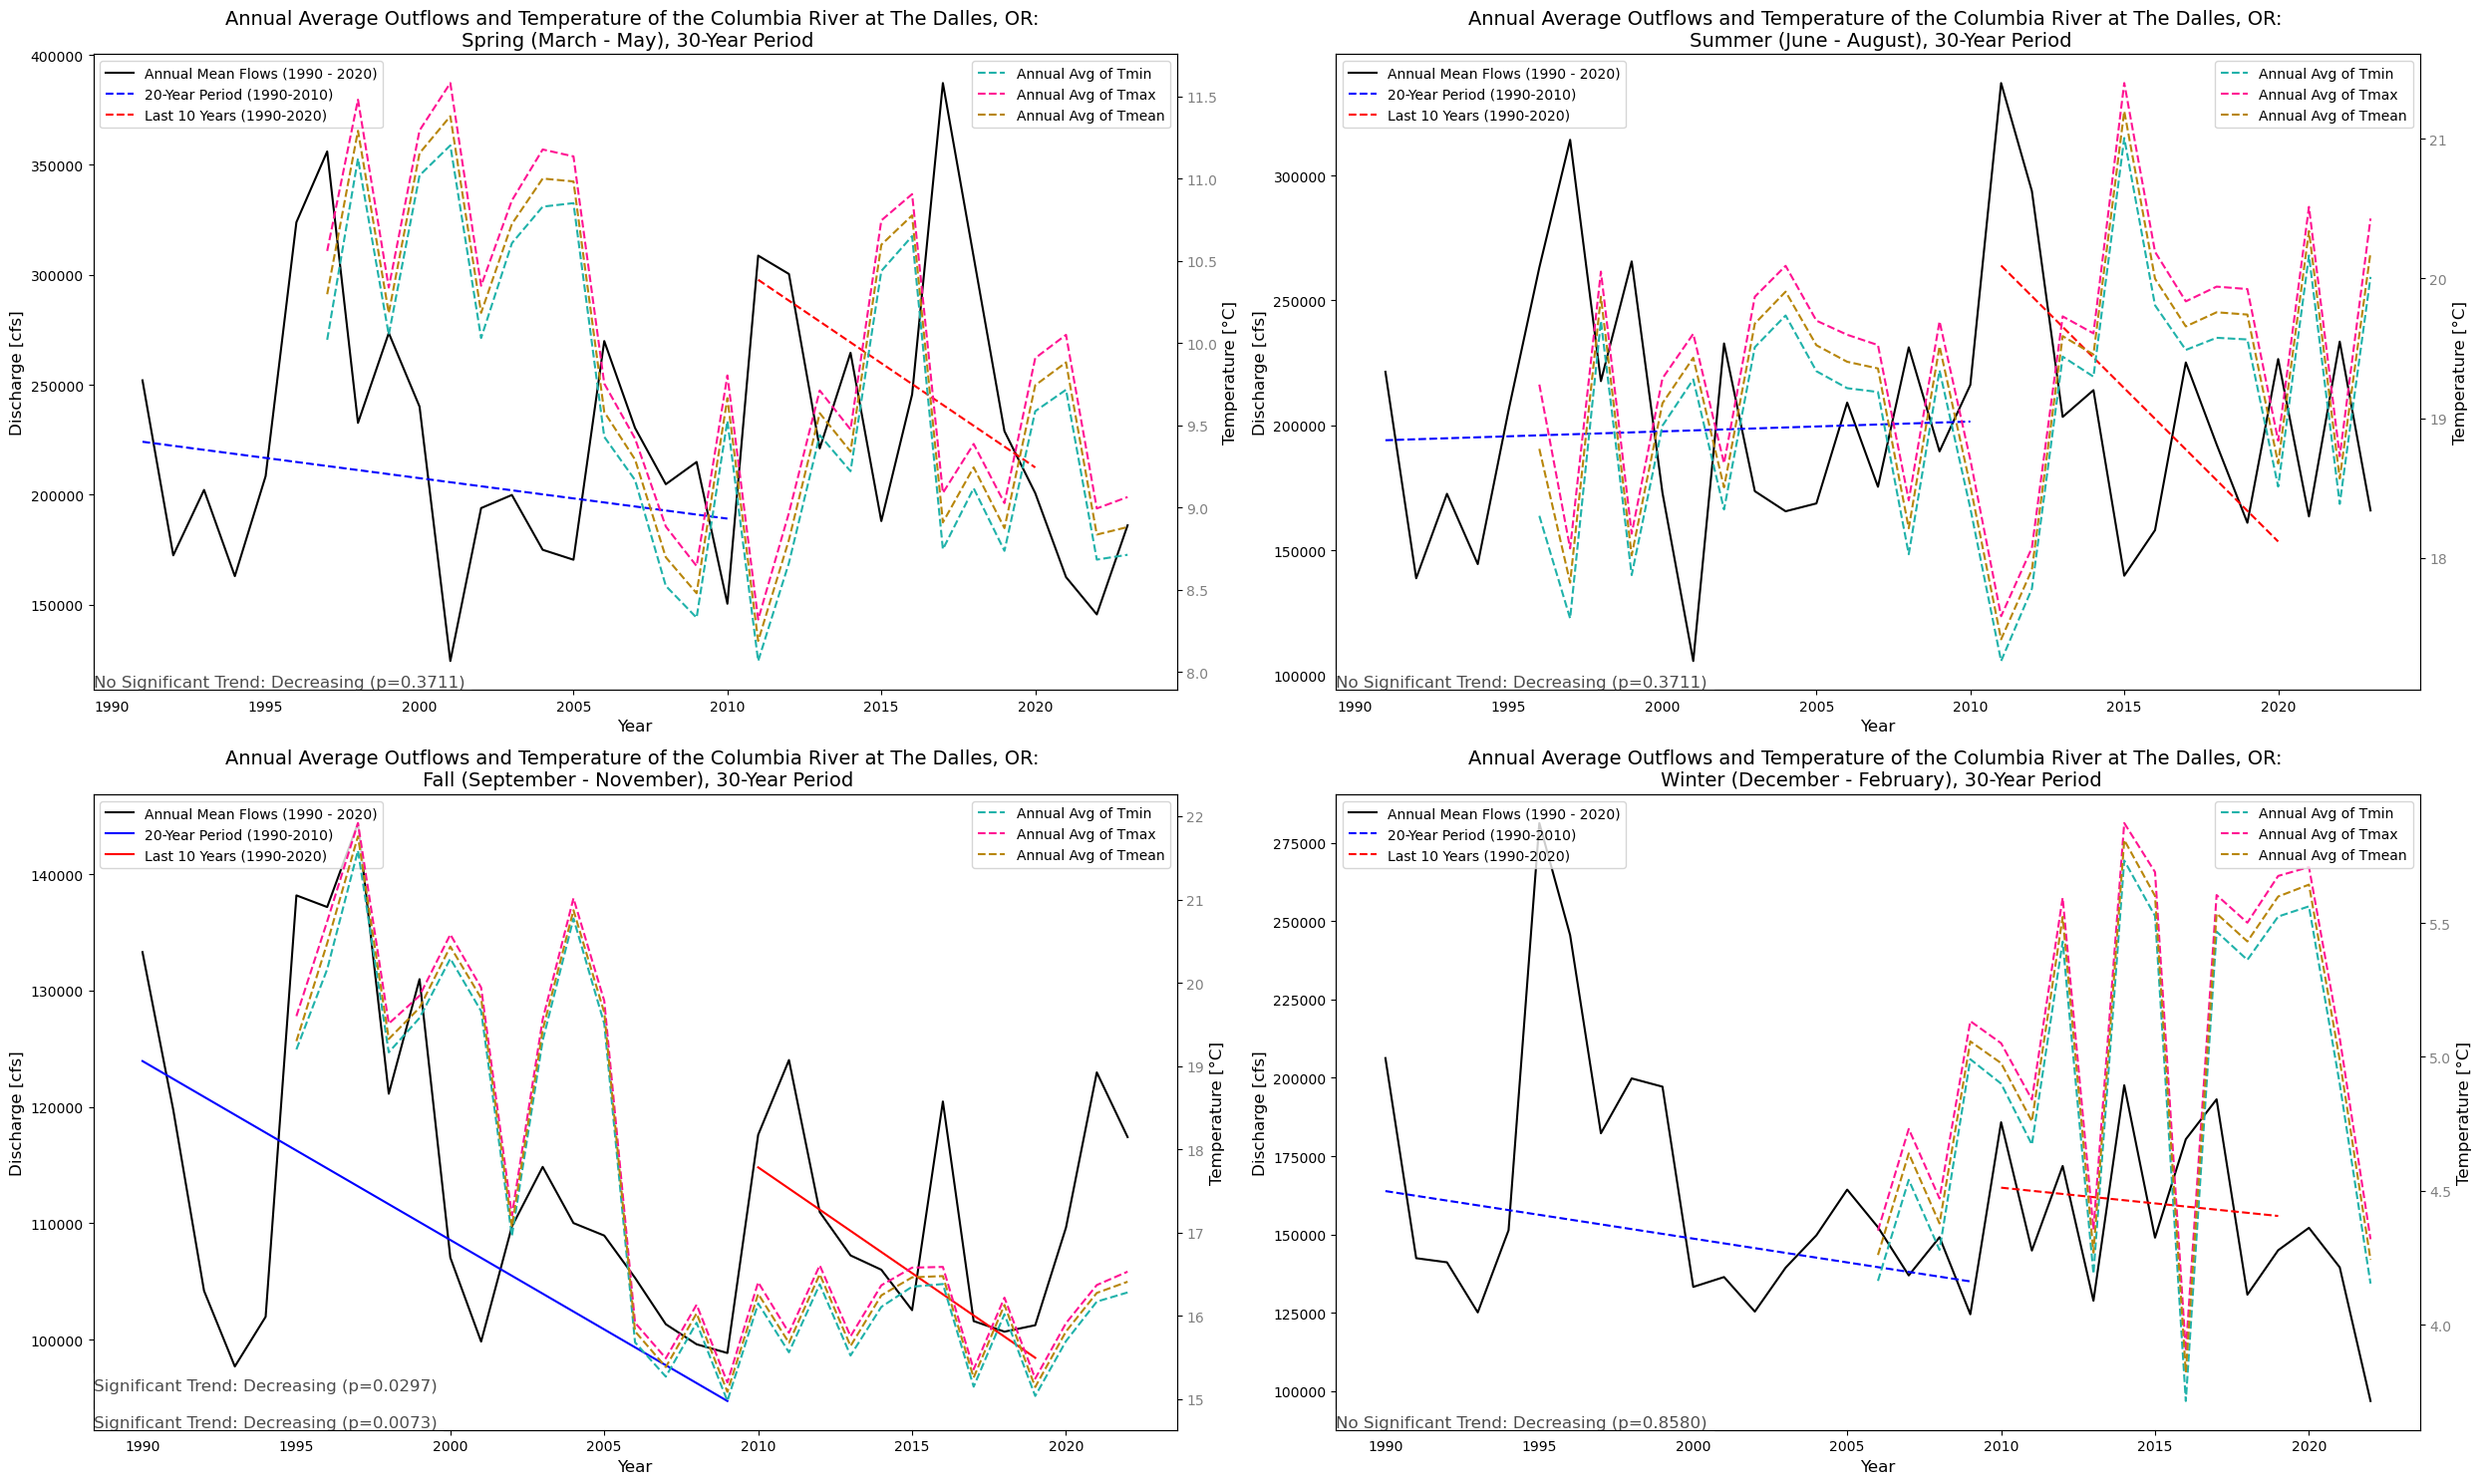

In [36]:
plt.figure(figsize=(25, 15))

for i, (season_name, season_months) in enumerate(seasons.items(), start=1):
    ax1 = plt.subplot(2, 2, i)
    df_season = return_months(df, season_months)
    
    # Resample and calculate seasonal mean flow and temperatures over 30 years
    flows = df_season['cfs'].resample('12MS').mean() 
    tmin = df_season['tmin'].resample('12MS').mean()
    tmax = df_season['tmax'].resample('12MS').mean()
    tmean = df_season['tmean'].resample('12MS').mean()

    # Plotting Peak Flows
    ax1.plot(flows.index.year, flows, label='Annual Mean Flows (1990 - 2020)', color='black')
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Discharge [cfs]', color='black', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='black')
    
    ax2 = ax1.twinx()
    ax2.plot(tmin.index.year, tmin, label='Annual Avg of Tmin', color='lightseagreen', linestyle='--')
    ax2.plot(tmax.index.year, tmax, label='Annual Avg of Tmax', color='deeppink', linestyle='--')
    ax2.plot(tmean.index.year, tmean, label='Annual Avg of Tmean', color='darkgoldenrod', linestyle='--')
    ax2.set_ylabel("Temperature [°C]", color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='grey')
    
    for period in periods:
        df_period = df_season.loc[period['start']:period['end']]
        if not df_period.empty:
            y = df_period['cfs'].resample('12MS').mean()
            x = np.arange(len(y))

            rejNull, p = mann_kendall(y.values, alpha=0.05)
            m_sen = sens_slope(y.values)
            slope, intercept = lr(x, y.values)

            # Assign different colors to the trendlines
            line_color = 'blue' if period['label'] == '(1990-2010)' else 'red'

            if rejNull:
                line = 'solid'
            else:
                line = 'dashed'

            # Assign different labels for the periods
            slope_label = "20-Year Period (1990-2010)" if period['label'] == '(1990-2010)' else "Last 10 Years (1990-2020)"


            trend_text = "Significant Trend" if rejNull else "No Significant Trend"
            trend_direction = "Increasing" if m_sen > 0 else "Decreasing"
            p_value_text = f"p={p:.4f}"
            annotation_text = f"{trend_text}: {trend_direction} ({p_value_text})"
            
            # Correcting the position and adding the annotation text
            # Calculate the position based on the axes limits
            x_lim = ax1.get_xlim()
            y_lim = ax1.get_ylim()

            text_x = x_lim[0]  # Use the right end of the x-axis
            text_y = y_lim[0]  # Use the lower end of the y-axis

            # Use horizontal and vertical alignment to position the text
            ax1.text(text_x, text_y, annotation_text, fontsize=12, horizontalalignment='left', verticalalignment='bottom', color='black', backgroundcolor='white', alpha=0.7)            
            
            # Sen's Slope Trend 
            ax1.plot(y.index.year, np.median(y) + m_sen * (x - np.median(x)), linestyle=line, label=slope_label, color=line_color)
            
    ax1.set_title(f"Annual Average Outflows and Temperature of the Columbia River at The Dalles, OR: \n {season_name}, 30-Year Period", fontsize=14)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()

plt.savefig("01_seasonal-mean-dalles-30yr.png", dpi=300)

plt.show()

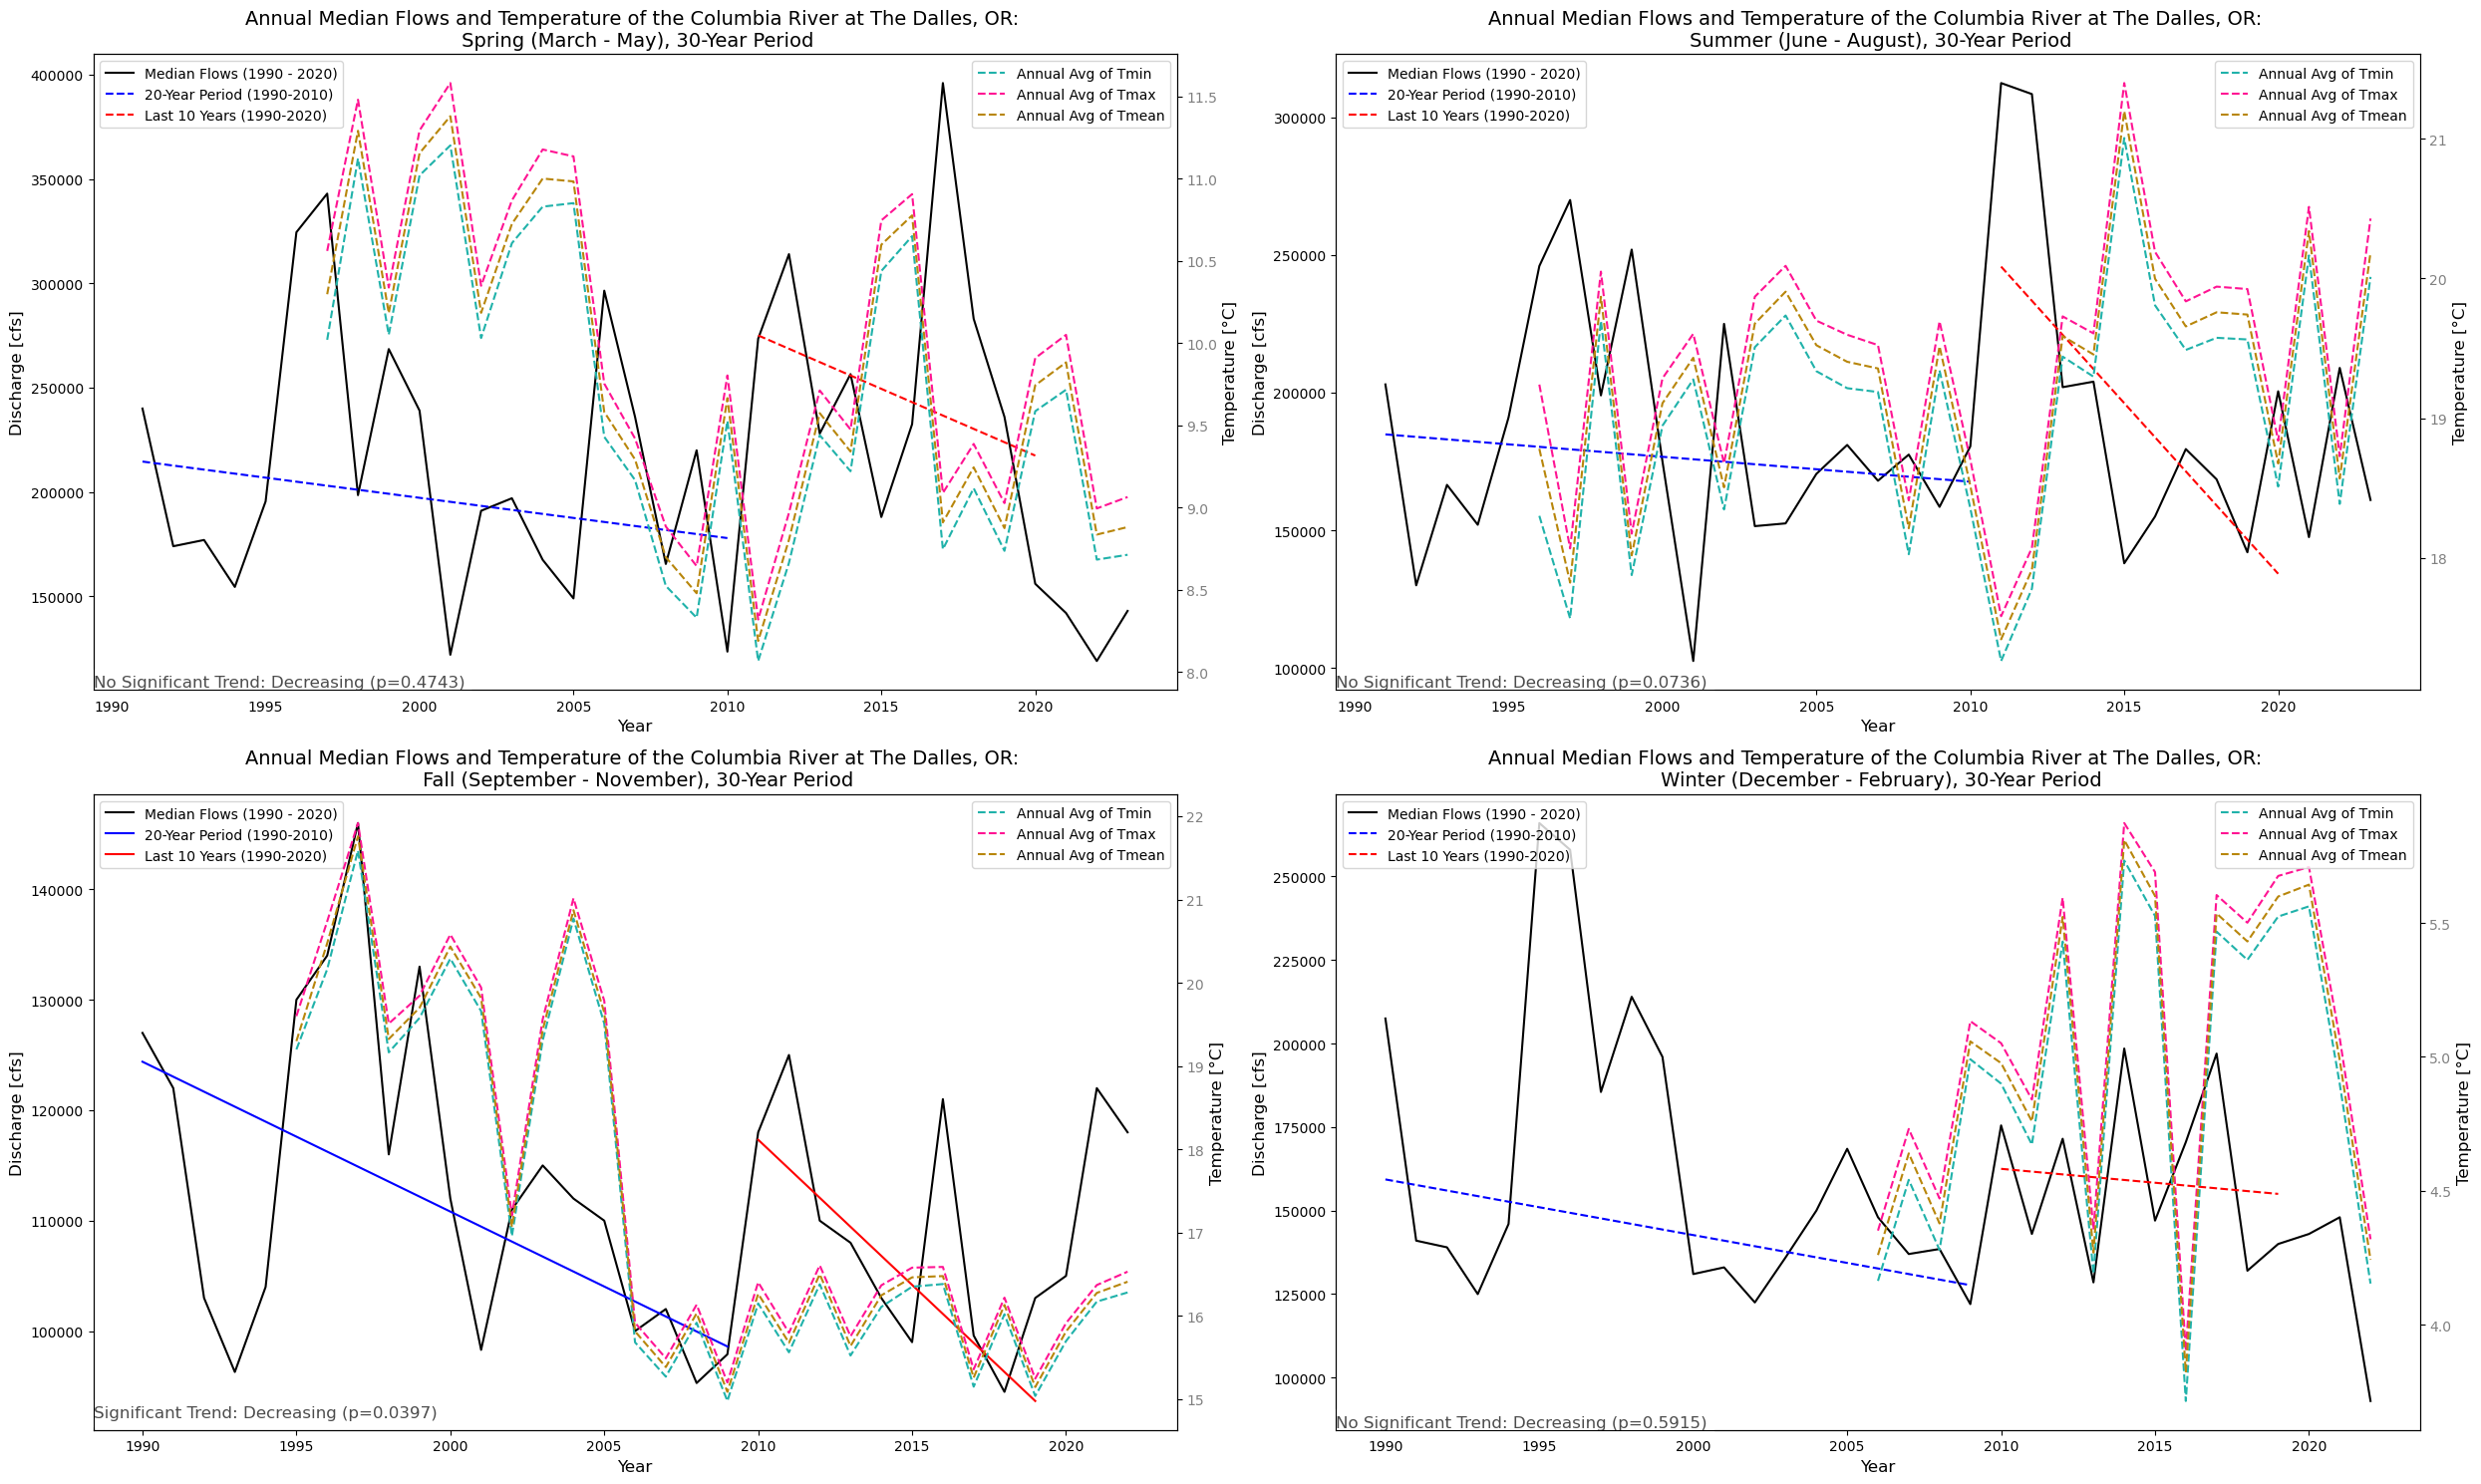

In [37]:
plt.figure(figsize=(25, 15))

for i, (season_name, season_months) in enumerate(seasons.items(), start=1):
    ax1 = plt.subplot(2, 2, i)
    df_season = return_months(df, season_months)
    
    # Resample and calculate seasonal median flow and temperatures over 30 years
    flows = df_season['cfs'].resample('12MS').median() 
    tmin = df_season['tmin'].resample('12MS').mean()
    tmax = df_season['tmax'].resample('12MS').mean()
    tmean = df_season['tmean'].resample('12MS').mean()

    # Plotting Median Flows
    ax1.plot(flows.index.year, flows, label='Median Flows (1990 - 2020)', color='black')
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Discharge [cfs]', color='black', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='black')
    
    ax2 = ax1.twinx()
    ax2.plot(tmin.index.year, tmin, label='Annual Avg of Tmin', color='lightseagreen', linestyle='--')
    ax2.plot(tmax.index.year, tmax, label='Annual Avg of Tmax', color='deeppink', linestyle='--')
    ax2.plot(tmean.index.year, tmean, label='Annual Avg of Tmean', color='darkgoldenrod', linestyle='--')
    ax2.set_ylabel("Temperature [°C]", color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='grey')
    
    for period in periods:
        df_period = df_season.loc[period['start']:period['end']]
        if not df_period.empty:
            y = df_period['cfs'].resample('12MS').median()
            x = np.arange(len(y))

            rejNull, p = mann_kendall(y.values, alpha=0.05)
            m_sen = sens_slope(y.values)
            slope, intercept = lr(x, y.values)

            # Assign different colors to the trendlines
            line_color = 'blue' if period['label'] == '(1990-2010)' else 'red'

            if rejNull:
                line = 'solid'
            else:
                line = 'dashed'

            # Assign different labels for the periods
            slope_label = "20-Year Period (1990-2010)" if period['label'] == '(1990-2010)' else "Last 10 Years (1990-2020)"


            trend_text = "Significant Trend" if rejNull else "No Significant Trend"
            trend_direction = "Increasing" if m_sen > 0 else "Decreasing"
            p_value_text = f"p={p:.4f}"
            annotation_text = f"{trend_text}: {trend_direction} ({p_value_text})"
            
            # Correcting the position and adding the annotation text
            # Calculate the position based on the axes limits
            x_lim = ax1.get_xlim()
            y_lim = ax1.get_ylim()

            text_x = x_lim[0]  # Use the right end of the x-axis
            text_y = y_lim[0]  # Use the lower end of the y-axis

            # Use horizontal and vertical alignment to position the text
            ax1.text(text_x, text_y, annotation_text, fontsize=12, horizontalalignment='left', verticalalignment='bottom', color='black', backgroundcolor='white', alpha=0.7)            
            
            # Sen's Slope Trend 
            ax1.plot(y.index.year, np.median(y) + m_sen * (x - np.median(x)), linestyle=line, label=slope_label, color=line_color)
            
    ax1.set_title(f"Annual Median Flows and Temperature of the Columbia River at The Dalles, OR: \n {season_name}, 30-Year Period", fontsize=14)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()

plt.savefig("01_seasonal-median-dalles-30yr.png", dpi=300)

plt.show()


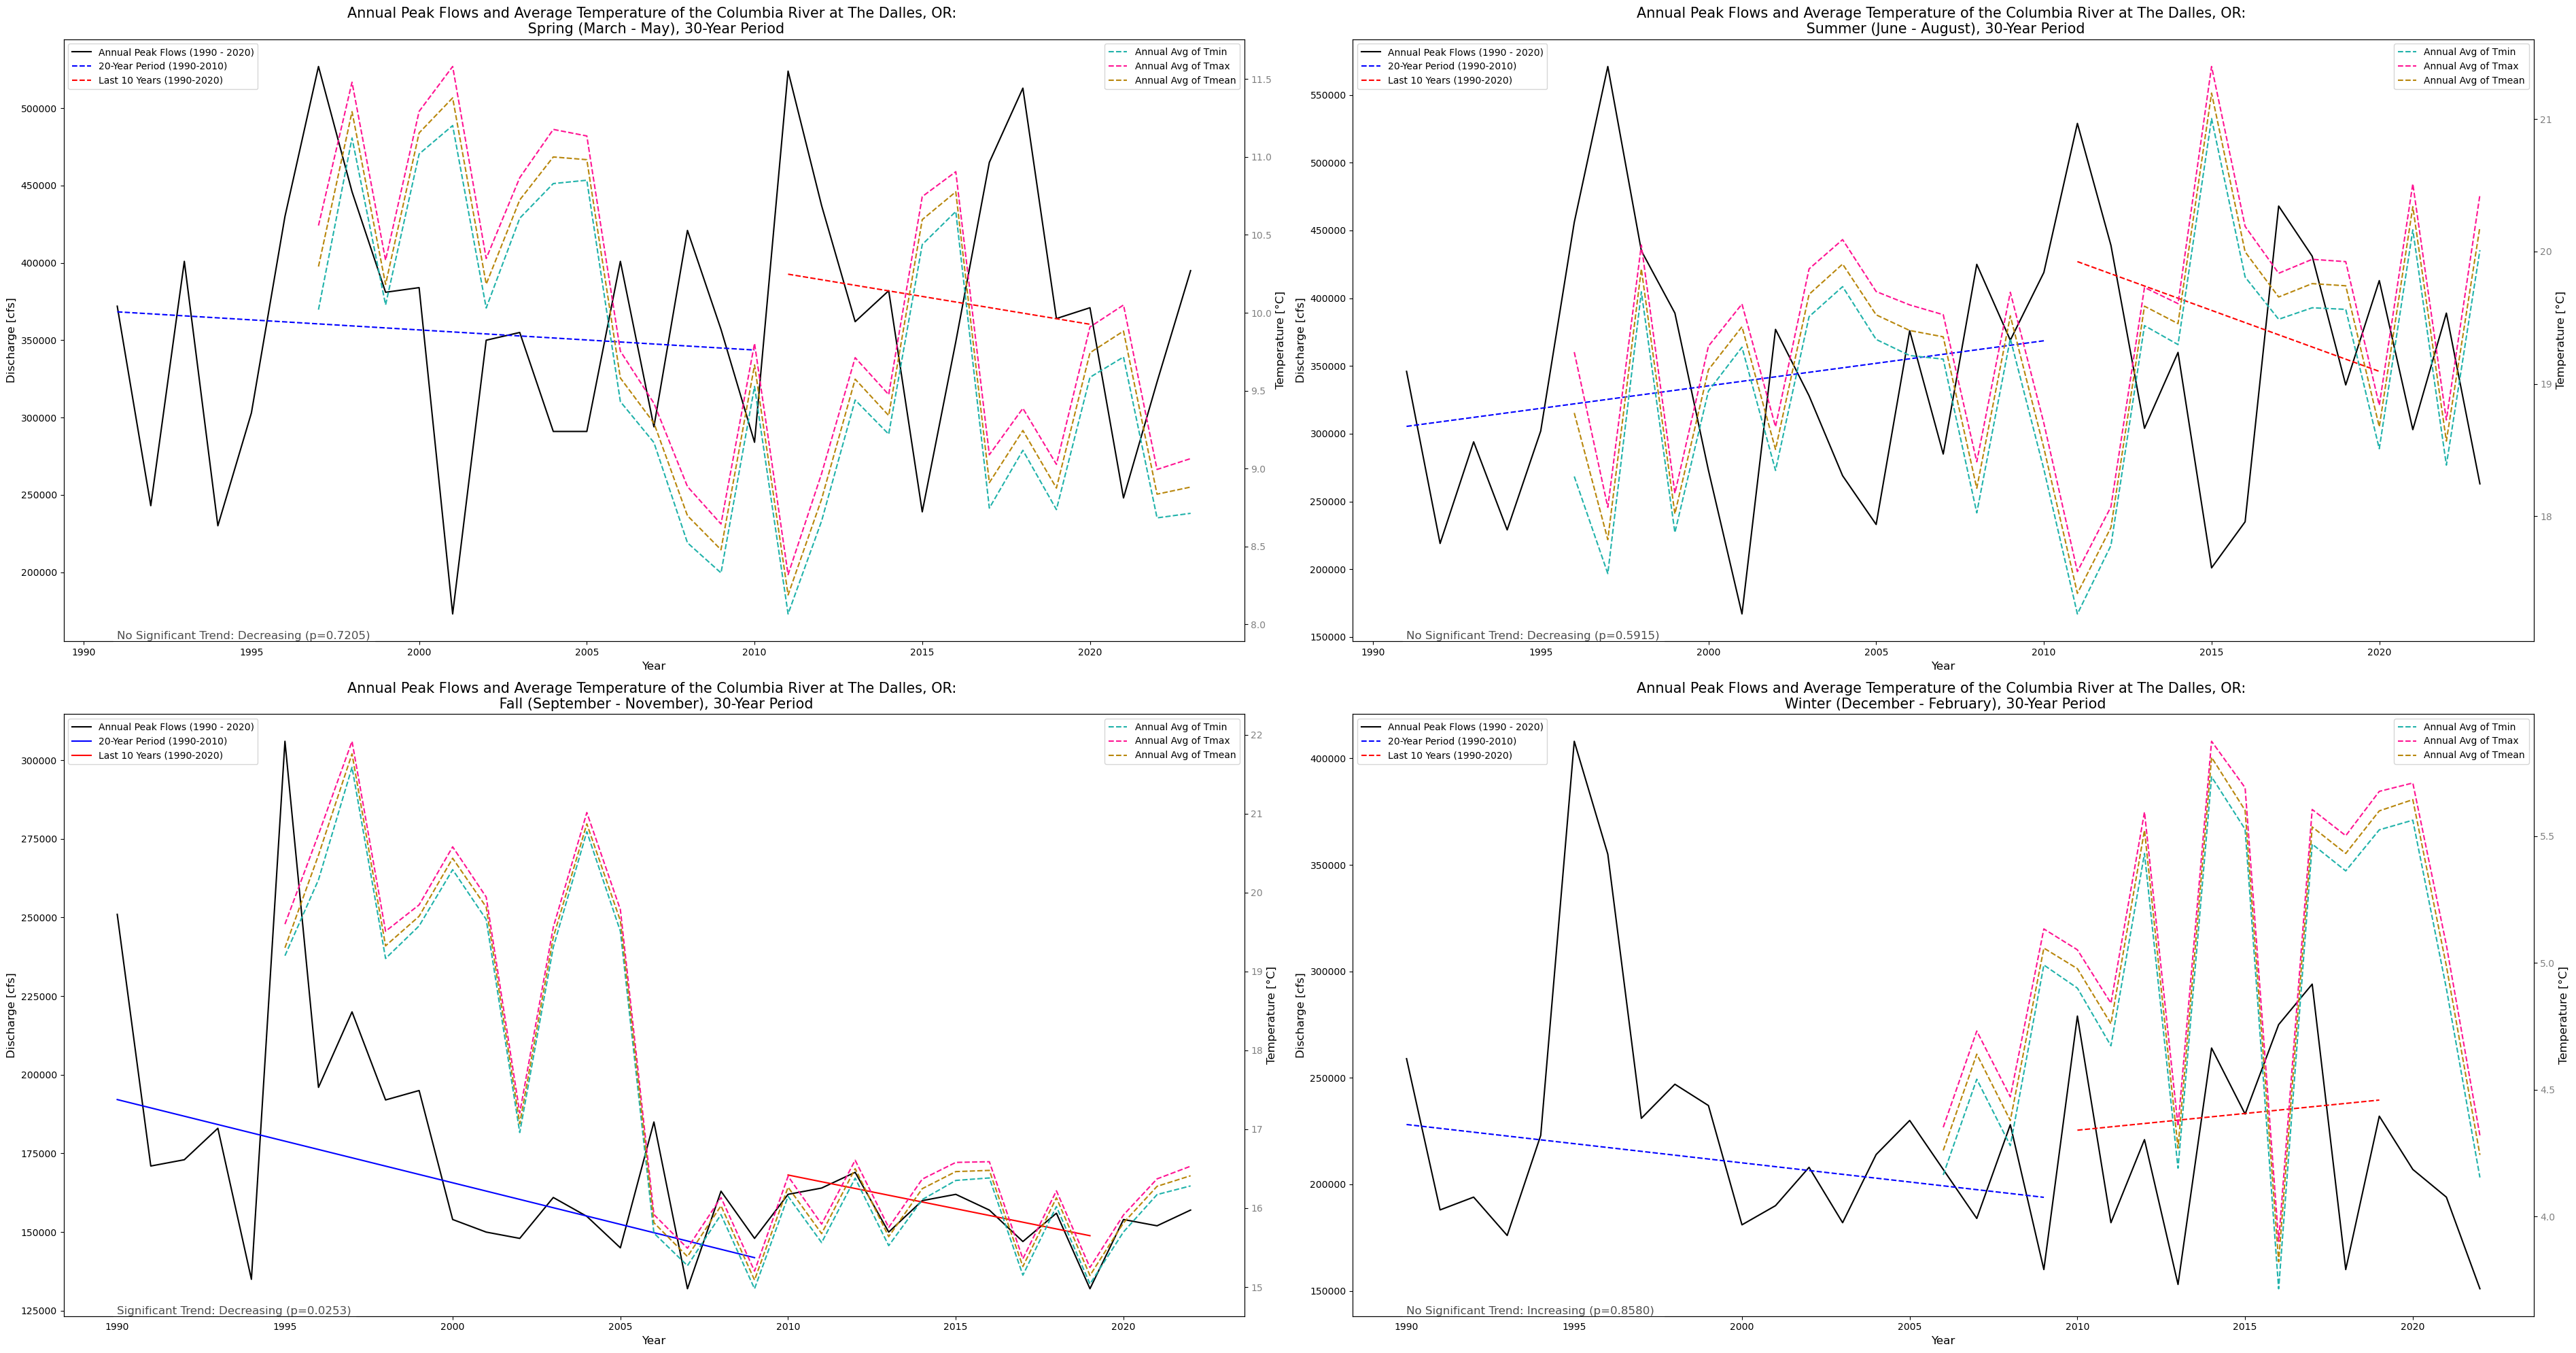

In [23]:
plt.figure(figsize=(38, 20))

for i, (season_name, season_months) in enumerate(seasons.items(), start=1):
    ax1 = plt.subplot(2, 2, i)
    df_season = return_months(df, season_months)
    
    # Resample and calculate peak flows and temperatures
    peak_flows = df_season['cfs'].resample('12MS').max() 
    tmin = df_season['tmin'].resample('12MS').mean()
    tmax = df_season['tmax'].resample('12MS').mean()
    tmean = df_season['tmean'].resample('12MS').mean()

    # Plotting Peak Flows
    ax1.plot(peak_flows.index.year, peak_flows, label='Annual Peak Flows (1990 - 2020)', color='black')
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Discharge [cfs]', color='black', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='black')
    
    ax2 = ax1.twinx()
    ax2.plot(tmin.index.year, tmin, label='Annual Avg of Tmin', color='lightseagreen', linestyle='--')
    ax2.plot(tmax.index.year, tmax, label='Annual Avg of Tmax', color='deeppink', linestyle='--')
    ax2.plot(tmean.index.year, tmean, label='Annual Avg of Tmean', color='darkgoldenrod', linestyle='--')
    ax2.set_ylabel("Temperature [°C]", color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='grey')
    
    for period in periods:
        df_period = df_season.loc[period['start']:period['end']]
        if not df_period.empty:
            y = df_period['cfs'].resample('12MS').max()
            x = np.arange(len(y))

            rejNull, p = mann_kendall(y.values, alpha=0.05)
            m_sen = sens_slope(y.values)
            slope, intercept = lr(x, y.values)

            # Assign different colors to the trendlines
            line_color = 'blue' if period['label'] == '(1990-2010)' else 'red'

            if rejNull:
                line = 'solid'
            else:
                line = 'dashed'

            # Assign different labels for the periods
            slope_label = "20-Year Period (1990-2010)" if period['label'] == '(1990-2010)' else "Last 10 Years (1990-2020)"


            trend_text = "Significant Trend" if rejNull else "No Significant Trend"
            trend_direction = "Increasing" if m_sen > 0 else "Decreasing"
            p_value_text = f"p={p:.4f}"
            annotation_text = f"{trend_text}: {trend_direction} ({p_value_text})"
            
            # Add Text
            text_x = peak_flows.index.year[0]  # Start year
            text_y = ax1.get_ylim()[0]  # Top of the plot
            ax1.text(text_x, text_y, annotation_text, fontsize=12, verticalalignment='bottom', color='black', backgroundcolor='white', alpha=0.7)
            
            
            # Sen's Slope Trend 
            ax1.plot(y.index.year, np.median(y) + m_sen * (x - np.median(x)), linestyle=line, label=slope_label, color=line_color)

    ax1.set_title(f"Annual Peak Flows and Average Temperature of the Columbia River at The Dalles, OR: \n {season_name}, 30-Year Period", fontsize=15)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Adjust spacing between the plots
plt.subplots_adjust(wspace=0.3, hspace=0.3) 

plt.tight_layout()
plt.savefig("01_seasonal-peak-dalles-30yr.png", dpi=300)
plt.show()

### Spring (March - May) Plot:
* **Discharge**: The black line represents the annual peak flows, showing variability over the years without a clear long-term trend.
* **Temperature**: The dashed lines in various colors represent the annual average temperatures (minimum, maximum, and mean).
* **Trend**: A blue solid line indicates the trend in peak flows during the 20-year period (1990-2010), and the red dashed line represents the trend in the last 10 years (2010-2020). In this case, there is no statistically significant trend in peak flows as annotated by "No Significant Trend: Decreasing (p=0.7205)", suggesting that despite a visual decrease, it is not statistically significant.


### Summer (June - August) Plot:
* **Discharge**: The pattern of annual peak flows shows high variation year-on-year with no discernible trend.
* **Temperature**: The temperature trends again are represented by dashed lines, showing fluctuations but no clear directional trend.
* **Trend**: Similar to Spring, both trend lines for the defined periods are present, but the annotation indicates "No Significant Trend: Decreasing (p=0.5915)" for the peak flows, meaning any decrease is not statistically confirmed.


### Fall (September - November) Plot:
* **Discharge**: The peak flows show a decreasing trend over the years, which seems more pronounced than in other seasons.
* **Temperature**: The temperature lines are closely packed, indicating less variability in temperatures across the years for Fall compared to other seasons.
* **Trend**: Here, the blue solid line shows a significant decreasing trend in peak flows for the period of 1990-2010 with a p-value of 0.0253, as indicated by the annotation "Significant Trend: Decreasing (p=0.0253)". This implies that the decrease in peak flows during the Fall season is statistically significant over this 20-year period.


### Winter (December - February) Plot:
* **Discharge**: The peak flow line shows dramatic fluctuations, which is typical for winter seasons where precipitation can vary widely.
* **Temperature**: The average temperature trends show seasonal variations, with some years warmer or cooler than others.
* **Trend**: Despite the visual appearance of a decreasing trend in the last 10 years (red dashed line), the annotation "No Significant Trend: Increasing (p=0.8580)" indicates that there is no statistically significant trend, and any apparent increase in peak flows is not supported by the statistical test.


### Overall Assessment:
The detailed annotations in each plot are critical, as they convey the result of statistical tests rather than relying solely on visual interpretation, which can be misleading. The use of p-values (probability values) allows for determining the statistical significance of trends. A p-value below a certain threshold (commonly 0.05) indicates a statistically significant trend.


### For peak flows:
Only the Fall season shows a statistically significant decreasing trend over the 20-year period from 1990 to 2010.
Other seasons do not show statistically significant trends, despite what the visual lines might suggest.


### For temperatures:
The plots do not contain annotations for the significance of temperature trends, so we cannot conclude from these images alone whether the changes in temperatures are statistically significant. However, they do provide a visual representation of the variability in temperatures over the same time frames.

In [27]:
df_season_clean = df_season.dropna(subset=['tmean'])


In [28]:
tmean_filled = tmean.fillna(tmean.mean())

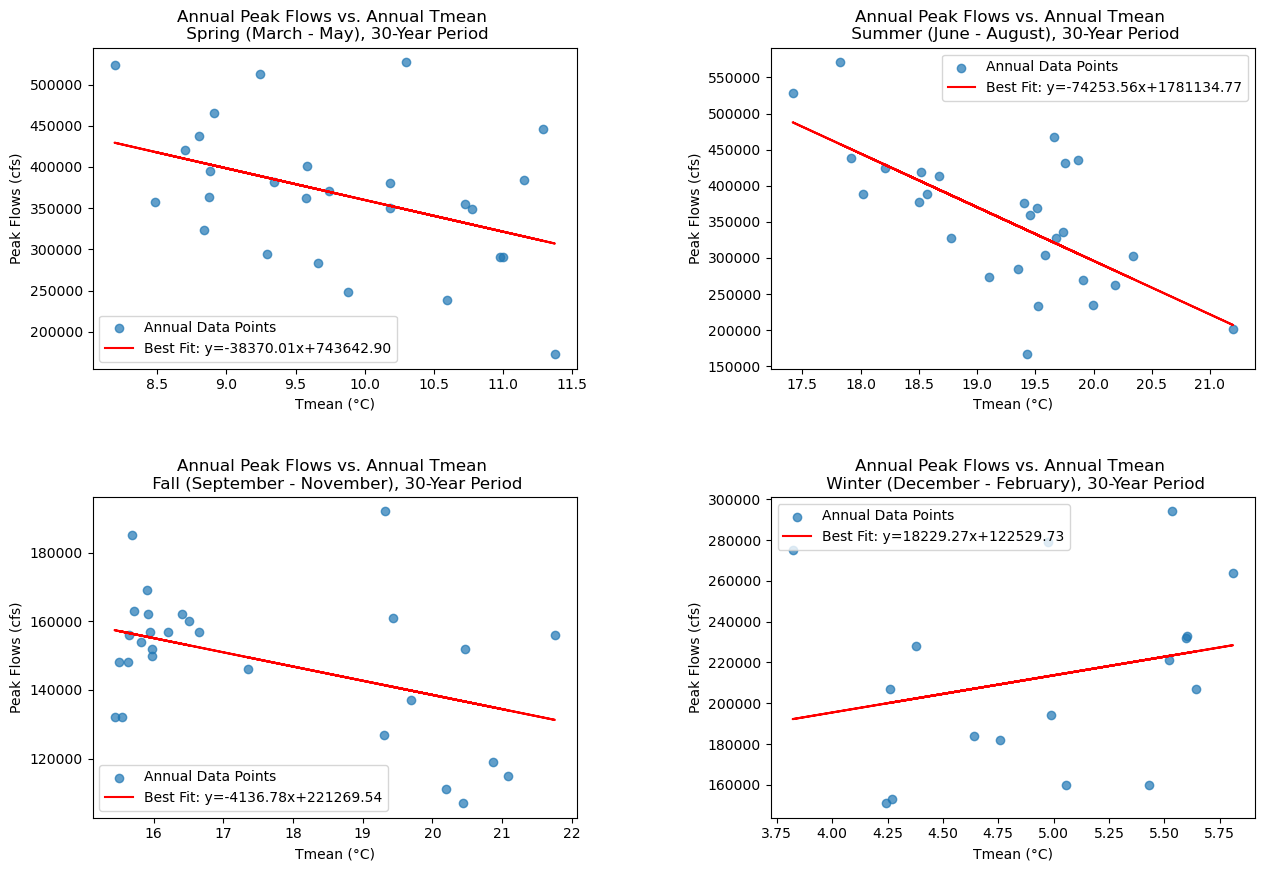

In [29]:
num_seasons = len(seasons)  # The total number of seasons
rows, cols = 2, 2  # Define the grid size

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))  
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust the space between plots

for i, (season_name, season_months) in enumerate(seasons.items(), start=0):
    # Determine the current subplot position
    row = i // cols
    col = i % cols
    ax = axs[row, col]  # Get the current axes
    
    df_season = return_months(df, season_months)
    df_season_clean = df_season.dropna(subset=['tmean'])
    
    tmean_clean = df_season_clean['tmean'].resample('12MS').mean()
    peak_flows_clean = df_season_clean['cfs'].resample('12MS').max()
    
    if len(tmean_clean) > 1 and len(peak_flows_clean) > 1:
        m, b = np.polyfit(tmean_clean, peak_flows_clean, 1)
    
        ax.scatter(tmean_clean, peak_flows_clean, label='Annual Data Points', alpha=0.7)
        ax.plot(tmean_clean, m*tmean_clean + b, color='red', label=f'Best Fit: y={m:.2f}x+{b:.2f}')
    
    ax.set_title(f'Annual Peak Flows vs. Annual Tmean \n {season_name}, 30-Year Period')
    ax.set_xlabel('Tmean (°C)')
    ax.set_ylabel('Peak Flows (cfs)')
    ax.legend()

plt.show()


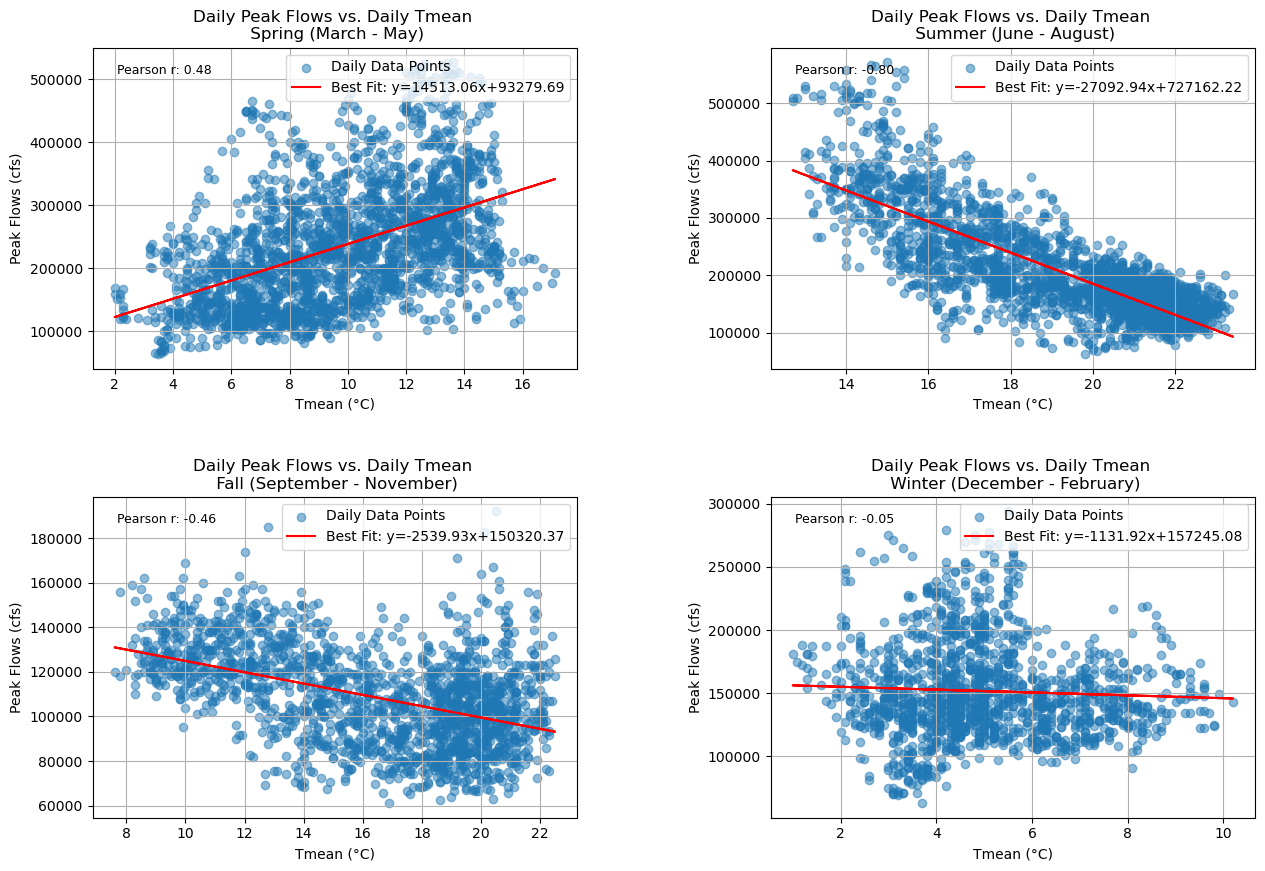

In [30]:
from scipy.stats import pearsonr

num_seasons = len(seasons) 
rows, cols = 2, 2

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))  
fig.subplots_adjust(hspace=0.4, wspace=0.4) 

for i, (season_name, season_months) in enumerate(seasons.items(), start=0):
    row, col = divmod(i, cols)
    df_season = return_months(df, season_months)
    df_season_clean = df_season.dropna(subset=['tmean'])

    tmean_daily = df_season_clean['tmean'].resample('D').mean()
    peak_flows_daily = df_season_clean['cfs'].resample('D').max()
    
    common_idx = tmean_daily.notna() & peak_flows_daily.notna()
    tmean_clean = tmean_daily[common_idx]
    peak_flows_clean = peak_flows_daily[common_idx]

    if len(tmean_clean) > 1 and len(peak_flows_clean) > 1:
        m, b = np.polyfit(tmean_clean, peak_flows_clean, 1)
        correlation_coefficient, _ = pearsonr(tmean_clean, peak_flows_clean)
     
        axs[row, col].scatter(tmean_clean, peak_flows_clean, label='Daily Data Points', alpha=0.5)
        axs[row, col].plot(tmean_clean, m*tmean_clean + b, color='red', label=f'Best Fit: y={m:.2f}x+{b:.2f}')
        axs[row, col].text(0.05, 0.95, f'Pearson r: {correlation_coefficient:.2f}', transform=axs[row, col].transAxes, fontsize=9, verticalalignment='top')
    
    axs[row, col].set_title(f'Daily Peak Flows vs. Daily Tmean \n {season_name}')
    axs[row, col].set_xlabel('Tmean (°C)')
    axs[row, col].set_ylabel('Peak Flows (cfs)')
    axs[row, col].legend(loc='upper right')
    axs[row, col].grid(True)

plt.savefig("01_dailypeakflow-dailymeantemp-scatter30yr.png", dpi=300)

plt.show()

### Spring: 
* There's a positive correlation indicated by an upward-sloping line. This suggests that as the temperature increases, the peak flows also tend to increase. This might be due to melting snow and ice contributing to the river flow as temperatures rise.

### Summer: 
* There's a negative correlation shown by a downward-sloping line. This implies that higher temperatures may be associated with lower peak flows, possibly due to higher evaporation rates or reduced snowmelt.

### Fall: 
* Similar to summer, there's a negative correlation, with the best fit line sloping downwards. This indicates that the peak flows decrease as the temperature increases.

### Winter: 
* The correlation here is not as clear as in other seasons. The best fit line is relatively flat, which suggests that there's a weak or no significant relationship between the temperature and peak flows during winter. This could be due to the river's flow being less dependent on temperature changes in the winter months, potentially because the flow could be influenced by factors like ice cover or consistent precipitation patterns.

The presence of a strong positive or negative slope in the scatter plots would imply a strong relationship between temperature and peak flows. However, the winter plot shows that this relationship is not consistent across seasons, and there may be other seasonal factors affecting river flows.

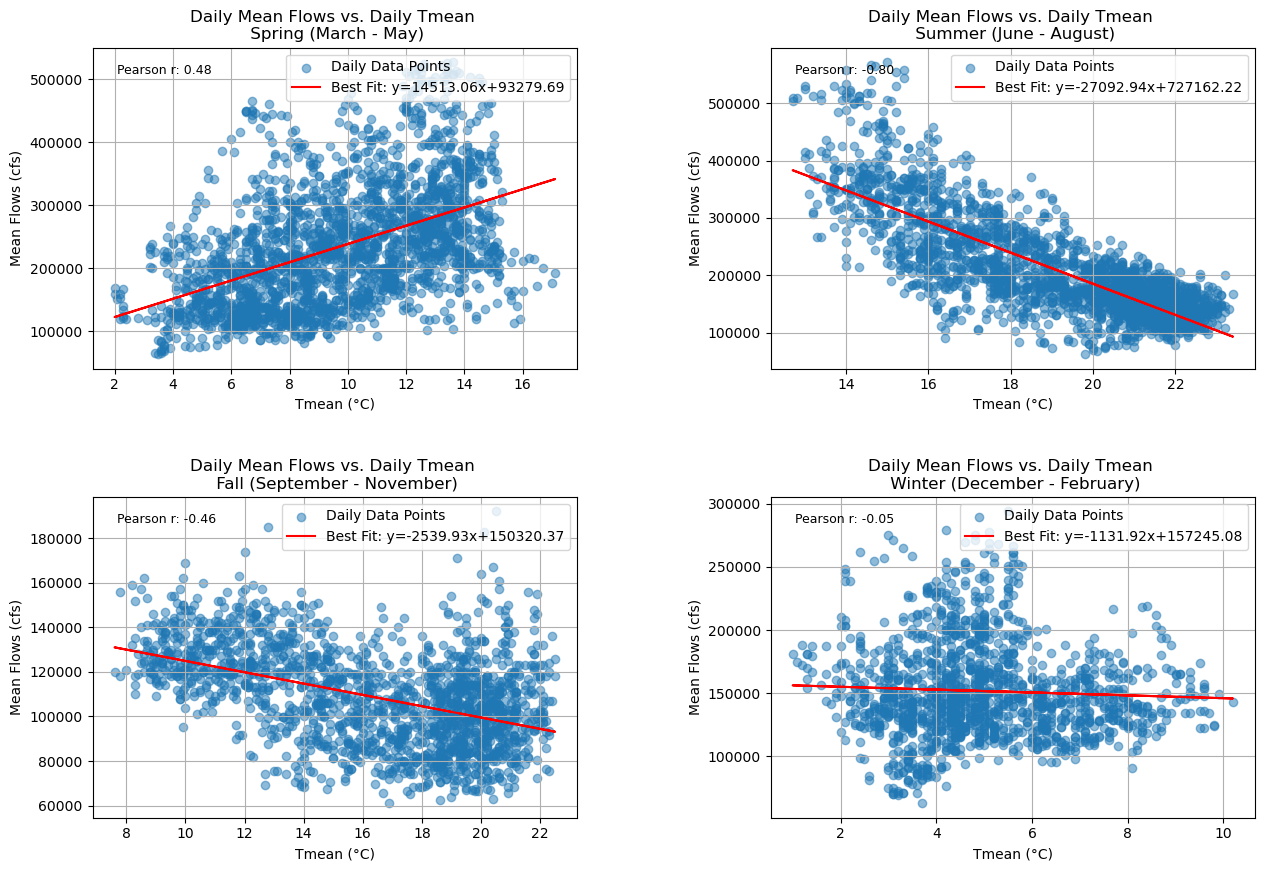

In [26]:
from scipy.stats import pearsonr

num_seasons = len(seasons)  
rows, cols = 2, 2

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))  
fig.subplots_adjust(hspace=0.4, wspace=0.4) 

for i, (season_name, season_months) in enumerate(seasons.items(), start=0):
    row, col = divmod(i, cols)
    df_season = return_months(df, season_months)
    df_season_clean = df_season.dropna(subset=['tmean'])

    tmean_daily = df_season_clean['tmean'].resample('D').mean()
    mean_flows_daily = df_season_clean['cfs'].resample('D').mean()
    
    common_idx = tmean_daily.notna() & mean_flows_daily.notna()
    tmean_clean = tmean_daily[common_idx]
    mean_flows_clean = mean_flows_daily[common_idx]
    if len(tmean_clean) > 1 and len(mean_flows_clean) > 1:
        m, b = np.polyfit(tmean_clean, mean_flows_clean, 1)
        correlation_coefficient, _ = pearsonr(tmean_clean, mean_flows_clean)
     
        axs[row, col].scatter(tmean_clean, mean_flows_clean, label='Daily Data Points', alpha=0.5)
        axs[row, col].plot(tmean_clean, m*tmean_clean + b, color='red', label=f'Best Fit: y={m:.2f}x+{b:.2f}')
        axs[row, col].text(0.05, 0.95, f'Pearson r: {correlation_coefficient:.2f}', transform=axs[row, col].transAxes, fontsize=9, verticalalignment='top')
    
    axs[row, col].set_title(f'Daily Mean Flows vs. Daily Tmean \n {season_name}')
    axs[row, col].set_xlabel('Tmean (°C)')
    axs[row, col].set_ylabel('Mean Flows (cfs)')
    axs[row, col].legend(loc='upper right')
    axs[row, col].grid(True)
plt.savefig("01_dailymeanflow-dailymeantemp-scatter30yr.png", dpi=300)
plt.show()